# Playground

> Some initial design ideas

In [ ]:
#| default_exp playground

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
import itertools

## Creating the set of trials

In [ ]:
# Defining the two sets
Ss = ['L', 'R','L2','R2']
Rs = ['L', 'R']

# Generating all combinations by crossing the two sets
combinations_crossed = list(itertools.product(Ss, Rs, repeat=2))

# Convert to DataFrame
df_crossed = pd.DataFrame(combinations_crossed, columns=['S1', 'R1', 'S2', 'R2'])
df_crossed

,S1,R1,S2,R2
0,L,L,L,L
1,L,L,L,R
2,L,L,R,L
3,L,L,R,R
4,L,L,L2,L
...,...,...,...,...
59,R2,R,R,R
60,R2,R,L2,L
61,R2,R,L2,R
62,R2,R,R2,L


In [ ]:
def check_feature_match(row):
    # Creating lists from the first two and the last two columns
    list1 = [row['S1'], row['R1']]
    list2 = [row['S2'], row['R2']]

    # Comparing the lists
    if list1 == list2:
        return "complete_match"
    elif all(item1 != item2 for item1, item2 in zip(list1, list2)):
        return "complete_mismatch"
    else:
        return "partial_match"

In [ ]:
def get_possible_trial_sequences(Ss, Rs):
    #Ss = ['L', 'R']
    #Rs = ['L', 'R']
    
    # Generating all combinations by crossing the two sets
    combinations_crossed = list(itertools.product(Ss, Rs, repeat=2))
    
    # Convert to DataFrame
    df_permutations = pd.DataFrame(combinations_crossed, columns=['S1', 'R1', 'S2', 'R2'])
    
    # Convert to DataFrame
    #df_permutations = pd.DataFrame(permutations, columns=['S1', 'R1', 'S2', 'R2'])
    # Adding columns to check if S1 equals R1 and if S2 equals R2
    df_permutations['S1_R1_corresp'] = df_permutations['S1'].str[0] == df_permutations['R1'].str[0]
    df_permutations['S2_R2_corresp'] = df_permutations['S2'].str[0] == df_permutations['R2'].str[0]
    df_permutations['S_R_loc_rep'] = df_permutations['R1'].str[0] == df_permutations['R2'].str[0]
    df_permutations['S_loc_rep'] = df_permutations['S1'].str[0] == df_permutations['S2'].str[0]
    df_permutations['feature_match'] = df_permutations.apply(check_feature_match, axis=1)
    df_permutations['complete_match_mismatch'] = df_permutations.feature_match.isin(["complete_match", "complete_mismatch"])
    df_permutations['cC_iI'] = df_permutations['S1_R1_corresp'] == df_permutations['S2_R2_corresp']
    df_permutations = df_permutations.drop(columns = ['feature_match'])
    
    return df_permutations

Ss = ['L1','L2','L3','R1','R2','R3']
Rs = ['L', 'R']
possible_sequences = get_possible_trial_sequences(Ss, Rs)
possible_sequences

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L1,L,L1,L,True,True,True,True,True,True
1,L1,L,L1,R,True,False,False,True,False,False
2,L1,L,L2,L,True,True,True,True,False,True
3,L1,L,L2,R,True,False,False,True,True,False
4,L1,L,L3,L,True,True,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...
139,R3,R,R1,R,True,True,True,True,False,True
140,R3,R,R2,L,True,False,False,True,True,False
141,R3,R,R2,R,True,True,True,True,False,True
142,R3,R,R3,L,True,False,False,True,False,False


In [ ]:
def get_next_trial(possible_sequences, current = None):
    if type(current) == type(None):
        current = possible_sequences.sample(1)
    else:
        current = possible_sequences.query(f"(S1=='{current['S2'].values[0]}') and (R1=='{current['R2'].values[0]}')").sample(1)
    return current
    
    

In [ ]:
def get_baseline(N, possible_sequences):
    current = get_next_trial(possible_sequences)
    trials = [current]
    for i in range(N-1):
        current = get_next_trial(possible_sequences, current = current)
        trials.append(current)
    trials = pd.concat(trials, ignore_index = True)
    return trials

trials = get_baseline(10, possible_sequences)
    
        

In [ ]:
def check_prob_cC_iI(df):
    return df.cC_iI.mean()

def check_balance(df):
    agg = df.set_index(['S1','S2','R1','R2']).groupby('cC_iI').mean()
    imbalance = agg.loc[False] - agg.loc[True]
    return imbalance

In [ ]:
def get_adaptive_trials(df, possible_sequences):
    # Finding matching trials
    current = trials.iloc[[-1]]
    possible_sequences = possible_sequences.query(f"(S1=='{current['S2'].values[0]}') and (R1=='{current['R2'].values[0]}')")
    prob_cC_iI = check_prob_cC_iI(df)
    if prob_cC_iI >= .5:
        prob_cC_iI = "(cC_iI==False)"
    else:
        prob_cC_iI = "(cC_iI==True)"

    balance = check_balance(df)
    # Optimizing balance
    if "False" in prob_cC_iI:
        if balance.complete_match_mismatch < 0:
            complete_match_mismatch = "(complete_match_mismatch==True)"
        else:
            complete_match_mismatch = "(complete_match_mismatch==False)"
        if balance.S_loc_rep < 0:
            S_loc_rep = "(S_loc_rep==True)"
        else:
            S_loc_rep = "(S_loc_rep==False)"

        if balance.S_R_loc_rep < 0:
            S_R_loc_rep = "(S_R_loc_rep==True)"
        else:
            S_R_loc_rep = "(S_R_loc_rep==False)"
            
    else:
        if balance.complete_match_mismatch > 0:
            complete_match_mismatch = "(complete_match_mismatch==False)"
        else:
            complete_match_mismatch = "(complete_match_mismatch==True)"
        if balance.S_loc_rep > 0:
            S_loc_rep = "(S_loc_rep==True)"
        else:
            S_loc_rep = "(S_loc_rep==False)"

        if balance.S_R_loc_rep > 0:
            S_R_loc_rep = "(S_R_loc_rep==True)"
        else:
            S_R_loc_rep = "(S_R_loc_rep==False)"
    #best = possible_sequences.query(f"{prob_cC_iI} and {complete_match_mismatch} and {S_loc_rep}")
    #if len(best==0):
    best = possible_sequences.query(f"{prob_cC_iI} and {complete_match_mismatch}")
    even_better = possible_sequences.query(f"{prob_cC_iI} and {complete_match_mismatch} and {S_loc_rep}")
    perfect = possible_sequences.query(f"{prob_cC_iI} and {complete_match_mismatch} and {S_loc_rep} and {S_R_loc_rep}")
    if len(perfect):
        return perfect
    if len(even_better):
        return even_better
    if len(best):
        return best
    else:
        return possible_sequences


In [ ]:
trials = get_baseline(10, possible_sequences)
print(trials.cC_iI.mean())
print(check_balance(trials))

0.3
S1_R1_corresp              0.428571
S2_R2_corresp              0.571429
S_R_loc_rep               -0.714286
S_loc_rep                 -0.285714
complete_match_mismatch   -0.047619
dtype: float64


In [ ]:
def get_balanced_data(N, possible_sequences, baseline = 10):
    trials = get_baseline(baseline, possible_sequences)
    for i in range(N-baseline):
        best_trials = get_adaptive_trials(trials, possible_sequences)
        new_trial = best_trials.sample(1)
        trials.loc[len(trials.index)] = new_trial.iloc[0]
    return trials

In [ ]:
%%time
Ss = ['L1','L2','L3','R1','R2','R3']
Rs = ['L', 'R']
possible_sequences = get_possible_trial_sequences(Ss, Rs)
N = 30


blocks = []
imbalances = []
for i in range(1000):
    try:
        trials = get_balanced_data(30, possible_sequences)
        blocks.append(trials)
        imbalance = check_balance(trials)
        imbalance.loc['percent_cC_iI'] = check_prob_cC_iI(trials)
        imbalances.append(imbalance)
    except:
        pass

CPU times: user 3min 44s, sys: 684 ms, total: 3min 44s
Wall time: 3min 45s


In [ ]:
df = pd.DataFrame(imbalances)
df.query("(S_R_loc_rep<.1) and (S_R_loc_rep>-.1)")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
150,-0.200000,-0.666667,-0.066667,0.0,-0.400000,0.5
193,-0.266667,-0.733333,-0.066667,0.0,-0.400000,0.5
412,-0.133333,-0.600000,-0.066667,0.0,-0.466667,0.5
819,-0.266667,-0.733333,-0.066667,0.0,-0.400000,0.5
836,-0.133333,-0.733333,-0.066667,0.0,-0.466667,0.5


<Axes: >

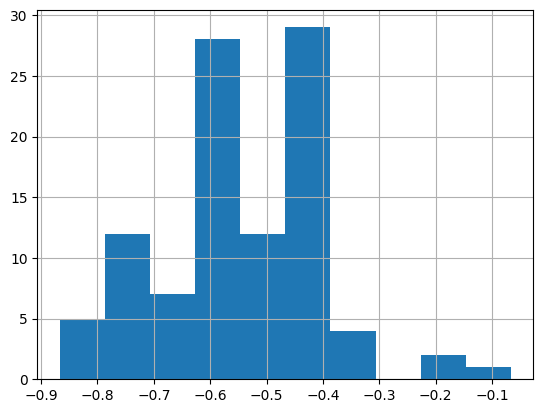

In [ ]:
df.S_R_loc_rep.hist()

In [ ]:
%%time
def check_balance(N, possible_sequences):
    current = possible_sequences.sample(1)
    trials = []
    trials.append(current)
    for i in range(N-1):
        current = possible_sequences.query(f"(S1=='{current['S2'].values[0]}') and (R1=='{current['R2'].values[0]}')").sample(1)
        trials.append(current)
    trials = pd.concat(trials, ignore_index = True)
    percent_cC_iI = trials.cC_iI.mean()
    agg = trials.set_index(['S1','S2','R1','R2']).groupby('cC_iI').mean()
    return trials, agg, percent_cC_iI
    
Ss = ['L1','L2','L3','R1','R2','R3']
Rs = ['L', 'R']
possible_sequences = get_possible_trial_sequences(Ss, Rs)
N = 30


blocks = []
imbalances = []
for i in range(100000):
    trials, agg, percent_cC_iI = check_balance(N, possible_sequences)
    blocks.append(trials)
    imbalance = agg.loc[False] - agg.loc[True]
    imbalance['percent_cC_iI'] = percent_cC_iI
    imbalances.append(imbalance)
    
df = pd.DataFrame(imbalances)
df.complete_match_mismatch.hist()

In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query("(percent_cC_iI>.45) and (percent_cC_iI<.55)").query("(S_R_loc_rep>-.05) and (S_R_loc_rep<.05)")

In [ ]:
#ss6_rs2_30t = df
#ss6_rs2_30t.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query("(percent_cC_iI>.45) and (percent_cC_iI<.55)").query("(S_R_loc_rep>-.05) and (S_R_loc_rep<.05)")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
936,-0.071429,-0.071429,-0.044643,0.330357,-0.017857,0.466667
2828,0.071429,0.071429,0.008929,0.133929,-0.008929,0.466667
3383,-0.062500,-0.062500,-0.026786,0.401786,0.026786,0.533333
16308,-0.066667,0.000000,0.000000,0.200000,0.000000,0.500000


In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05) ")

In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05) ")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
4,-0.200000,-0.133333,-0.200000,0.133333,0.000000,0.500000
12,0.187500,0.187500,-0.142857,0.142857,0.017857,0.533333
32,0.111111,0.111111,-0.277778,0.055556,-0.027778,0.600000
103,0.066667,0.133333,-0.133333,-0.066667,0.000000,0.500000
109,-0.185520,-0.108597,-0.167421,-0.244344,-0.027149,0.566667
...,...,...,...,...,...,...
19880,-0.033493,-0.124402,-0.282297,-0.191388,-0.019139,0.633333
19913,0.083333,0.083333,-0.166667,0.166667,0.000000,0.400000
19922,0.055556,0.055556,-0.305556,0.194444,0.027778,0.600000
19926,0.000000,0.000000,-0.055556,0.055556,0.000000,0.400000


In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query('percent_cC_iI==.5')

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
4,-0.200000,-0.133333,-0.200000,0.133333,0.0,0.5
103,0.066667,0.133333,-0.133333,-0.066667,0.0,0.5
418,-0.066667,-0.133333,-0.066667,0.000000,0.0,0.5
719,0.400000,0.466667,-0.200000,0.133333,0.0,0.5
745,0.133333,0.200000,-0.266667,-0.333333,0.0,0.5
...,...,...,...,...,...,...
18636,0.000000,-0.066667,-0.466667,0.000000,0.0,0.5
18801,-0.266667,-0.200000,-0.200000,-0.133333,0.0,0.5
19026,0.066667,0.000000,-0.533333,0.066667,0.0,0.5
19352,0.000000,0.066667,-0.266667,-0.066667,0.0,0.5


In [ ]:
df.query("(complete_match_mismatch>-.05) and (complete_match_mismatch<.05)").query("(percent_cC_iI>.45) and (percent_cC_iI<.55)").query("(S_R_loc_rep>-.05) and (S_R_loc_rep<.05)")

,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,percent_cC_iI
936,-0.071429,-0.071429,-0.044643,0.330357,-0.017857,0.466667
2828,0.071429,0.071429,0.008929,0.133929,-0.008929,0.466667
3383,-0.062500,-0.062500,-0.026786,0.401786,0.026786,0.533333
16308,-0.066667,0.000000,0.000000,0.200000,0.000000,0.500000


In [ ]:
blocks[16308]

,S1,R1,S2,R2,S1_R1_corresp,S2_R2_corresp,S_R_loc_rep,S_loc_rep,complete_match_mismatch,cC_iI
0,L3,R,R2,L,False,False,False,False,True,True
1,R2,L,L3,L,False,True,True,False,False,False
2,L3,L,R3,L,True,False,True,False,False,False
3,R3,L,L1,R,False,False,False,False,True,True
4,L1,R,L2,R,False,False,True,True,False,True
5,L2,R,L3,L,False,True,False,True,True,False
6,L3,L,L1,L,True,True,True,True,False,True
7,L1,L,R3,L,True,False,True,False,False,False
8,R3,L,L2,L,False,True,True,False,False,False
9,L2,L,R2,L,True,False,True,False,False,False


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()